In [11]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import gensim
import gensim.corpora as corpora
##import yfinance as yf
import re
import requests
from bs4 import BeautifulSoup
#import reticker
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from itertools import chain
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import percentile

In [3]:
df=pd.read_csv("reddit_wsb.csv")
df.head()

,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53187 entries, 0 to 53186
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      53187 non-null  object 
 1   score      53187 non-null  int64  
 2   id         53187 non-null  object 
 3   url        53187 non-null  object 
 4   comms_num  53187 non-null  int64  
 5   created    53187 non-null  float64
 6   body       24738 non-null  object 
 7   timestamp  53187 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 3.2+ MB


### Data Pre-Processing

In [5]:
df["body"] = df["body"].fillna("") ## fill nan's with empty
df["original_text"] = df["title"] + ' ' + df["body"] ## concatane body and title to create a new column called original_text
df = df.drop(columns = ["body", "title", "id", "url", "created"]) ## drop unrelated columns
df['length'] = df['original_text'].apply(len) ## create a length column
df.head()

,score,comms_num,timestamp,original_text,length
0,55,6,2021-01-28 21:37:41,"It's not about the money, it's about sending a...",60
1,110,23,2021-01-28 21:32:10,Math Professor Scott Steiner says the numbers ...,81
2,0,47,2021-01-28 21:30:35,Exit the system The CEO of NASDAQ pushed to ha...,1335
3,29,74,2021-01-28 21:28:57,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,76
4,71,156,2021-01-28 21:26:56,"Not to distract from GME, just thought our AMC...",80


In [6]:
def clean_text_date(text):
    text = text.lower()
    
    # remove emojis
    text = text.encode('ascii','ignore')
    text = text.decode()

    # replacing handlers with empty string
    text = re.sub('@[^\s]+',"",text)
    
    # remove punctuations and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    # replacing URLs with empty string
    text = re.sub(r"http\S+", "",text)

    # remove all the special characters
    text = ' '.join(re.findall(r'\w+', text))

    # replacing single characters with empty string
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    # remove stopwords
    text = ' '.join([word for word in text.split() if not word in set(stopwords.words('english'))])
    
    # words to singular forms
    lem = WordNetLemmatizer()
    text = lem.lemmatize(text)
    
    return text

In [7]:
# Text Preprocessing
df["text"] = df["original_text"].apply(lambda x : clean_text_date(x))

In [8]:
df.head()

,score,comms_num,timestamp,original_text,length,text
0,55,6,2021-01-28 21:37:41,"It's not about the money, it's about sending a...",60,money sending message
1,110,23,2021-01-28 21:32:10,Math Professor Scott Steiner says the numbers ...,81,math professor scott steiner says numbers spel...
2,0,47,2021-01-28 21:30:35,Exit the system The CEO of NASDAQ pushed to ha...,1335,exit system ceo nasdaq pushed halt trading giv...
3,29,74,2021-01-28 21:28:57,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,76,new sec filing gme someone less retarded pleas...
4,71,156,2021-01-28 21:26:56,"Not to distract from GME, just thought our AMC...",80,distract gme thought amc brothers aware


## Exploratory Data Analysis

### The Number of Posts vs DayofWeek

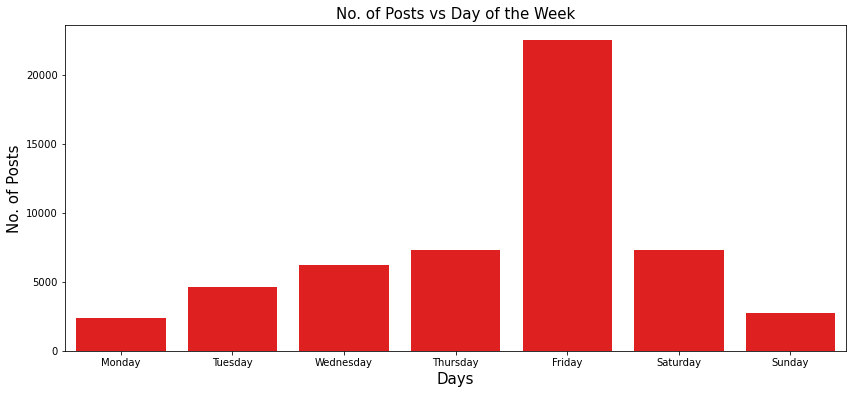

In [12]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

day_of_the_week = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
days_order = list(day_of_the_week.values())

df['Weekday'] = df['timestamp'].apply(lambda x : day_of_the_week[x.weekday()])

xs = df['Weekday'].value_counts().index
ys = df['Weekday'].value_counts().values

plt.figure(figsize=(14,6))

sns.barplot(x=xs, y=ys, order=days_order, color="red")

plt.title("No. of Posts vs Day of the Week", fontsize=15)

plt.xlabel("Days", fontsize=15)
plt.ylabel("No. of Posts", fontsize=15)

plt.show()

### Log Distribution of Upvotes, Comments and Length

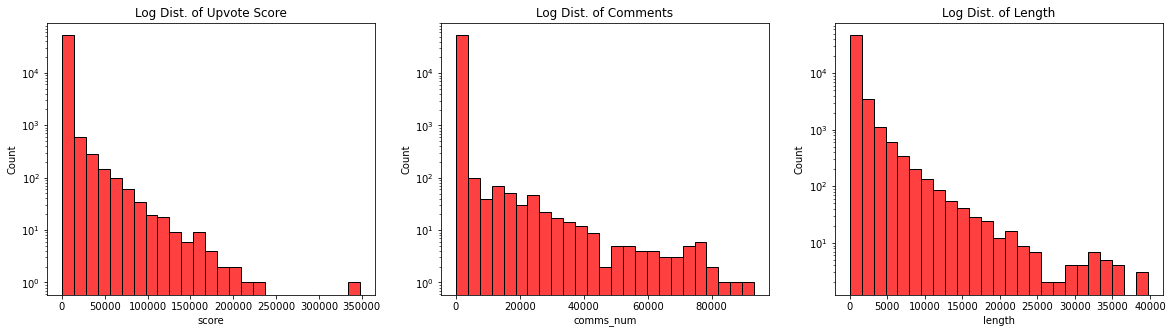

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
sns.histplot(x=df['score'], data=df, bins = 25, ax = ax[0],  color="red")
ax[0].set_title("Log Dist. of Upvote Score")

sns.histplot(x=df['comms_num'],data=df,  bins = 25, ax = ax[1], color="red")
ax[1].set_title("Log Dist. of Comments")

sns.histplot(x=df['length'], data=df, bins = 25, ax = ax[2], color="red")
ax[2].set_title("Log Dist. of Length")
plt.show()

### Most Mentioned Stocks

In [16]:
text_all = ' '.join(df["original_text"])

In [17]:
tickers = re.findall(r'[$][A-Za-z]{2,4}', text_all)
ticker_list = set([t.lower() for t in tickers])

In [18]:
# to rank the tickers by count:
# initializing the list
frequency = {}

# iterating over the list
for item in tickers:
   # checking the element in dictionary
   if item in frequency:
      # incrementing the counr
      frequency[item] += 1
   else:
      # initializing the count
      frequency[item] = 1

In [19]:
s_freq = sorted(frequency.items(), key=lambda item: item[1], reverse = True)
s_freq[:10]

[('$GME', 2790),
 ('$AMC', 854),
 ('$BB', 632),
 ('$NOK', 425),
 ('$RKT', 333),
 ('$UWMC', 247),
 ('$WISH', 245),
 ('$PLTR', 217),
 ('$RIDE', 209),
 ('$TSLA', 192)]

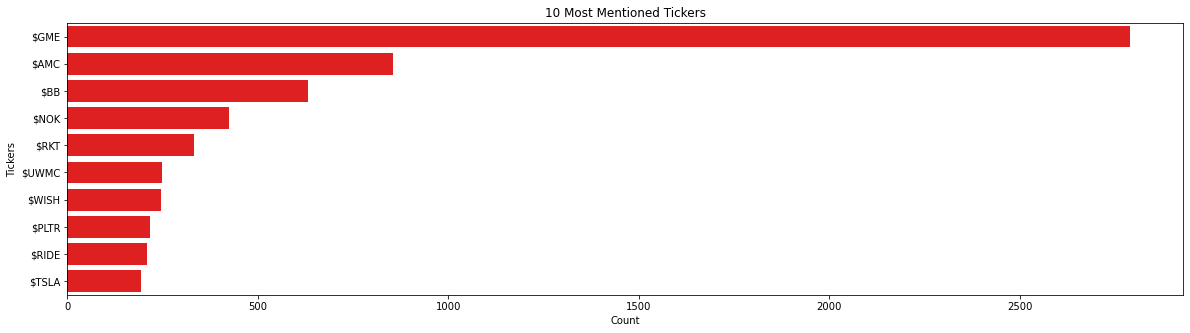

In [39]:
import seaborn as sns
from numpy import percentile

tickers=[word for (word, freq) in s_freq[:10]]
frq = [freq for (word, freq) in s_freq[:10]]
fig_dims = (20, 5)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(y=tickers, x=frq, color="red").set(title='10 Most Mentioned Tickers')
plt.xlabel("Count")
plt.ylabel("Tickers")

plt.show()

### Creating Columns by GME, AMC, BB, NOK, TSLA

In [40]:
df['GME'] = df.original_text.str.contains(r'\bgme\b |\bGME\b | \bGameStop\b | gamestop') 
df['GME'] = df['GME'].astype(int)

In [41]:
df['AMC'] = df.original_text.str.contains(r'\bamc\b |\bAMC\b') 
df['AMC'] = df['AMC'].astype(int)

In [42]:
df['BB'] = df.original_text.str.contains(r'\bbb\b |\bBB\b | \bBlackBerry\b | \bblackberry\b | \bBlackberry\b') 
df['BB'] = df['BB'].astype(int)

In [43]:
df['NOK'] = df.original_text.str.contains(r'\bnok\b |\bNOK\b | \bNokia\b | \bnokia\b ') 
df['NOK'] = df['NOK'].astype(int)

In [45]:
df['TSLA'] = df.original_text.str.contains(r'\btsla\b |\bTSLA\b | \bTesla\b | \btesla\b ') 
df['TSLA'] = df['TSLA'].astype(int)

In [46]:
df.head()

,score,comms_num,timestamp,original_text,length,text,Weekday,GME,AMC,BB,NOK,TSLA
0,55,6,2021-01-28 21:37:41,"It's not about the money, it's about sending a...",60,money sending message,Thursday,0,0,0,0,0
1,110,23,2021-01-28 21:32:10,Math Professor Scott Steiner says the numbers ...,81,math professor scott steiner says numbers spel...,Thursday,0,0,0,0,0
2,0,47,2021-01-28 21:30:35,Exit the system The CEO of NASDAQ pushed to ha...,1335,exit system ceo nasdaq pushed halt trading giv...,Thursday,1,0,0,0,0
3,29,74,2021-01-28 21:28:57,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,76,new sec filing gme someone less retarded pleas...,Thursday,0,0,0,0,0
4,71,156,2021-01-28 21:26:56,"Not to distract from GME, just thought our AMC...",80,distract gme thought amc brothers aware,Thursday,0,1,0,0,0


In [47]:
cond=(df['GME']>=1) | (df['AMC']>=1) | (df['BB']>=1) | (df['NOK']>=1) | (df['TSLA']>=1)## filter the dataset by tickers
cond2=df['text'].notna()
df=df[cond&cond2]
df.index=range(df.shape[0])#reset index num

In [48]:
df.head()

,score,comms_num,timestamp,original_text,length,text,Weekday,GME,AMC,BB,NOK,TSLA
0,0,47,2021-01-28 21:30:35,Exit the system The CEO of NASDAQ pushed to ha...,1335,exit system ceo nasdaq pushed halt trading giv...,Thursday,1,0,0,0,0
1,71,156,2021-01-28 21:26:56,"Not to distract from GME, just thought our AMC...",80,distract gme thought amc brothers aware,Thursday,0,1,0,0,0
2,200,161,2021-01-28 21:19:16,Currently Holding AMC and NOK - Is it retarded...,95,currently holding amc nok retarded think move ...,Thursday,1,1,0,1,0
3,222,70,2021-01-28 21:18:25,"We need to keep this movement going, we all ca...",786,need keep movement going make history believe ...,Thursday,0,1,0,0,0
4,562,97,2021-01-28 21:17:28,GME Premarket 🍁 Musk approved 🎮🛑💎✋,35,gme premarket musk approved,Thursday,1,0,0,0,0


### Dispersion Plot

In [49]:
tokens = nltk.word_tokenize(text_all)   # tokenize it
mytext = nltk.Text(tokens)         # turn text into a NLTK Text object

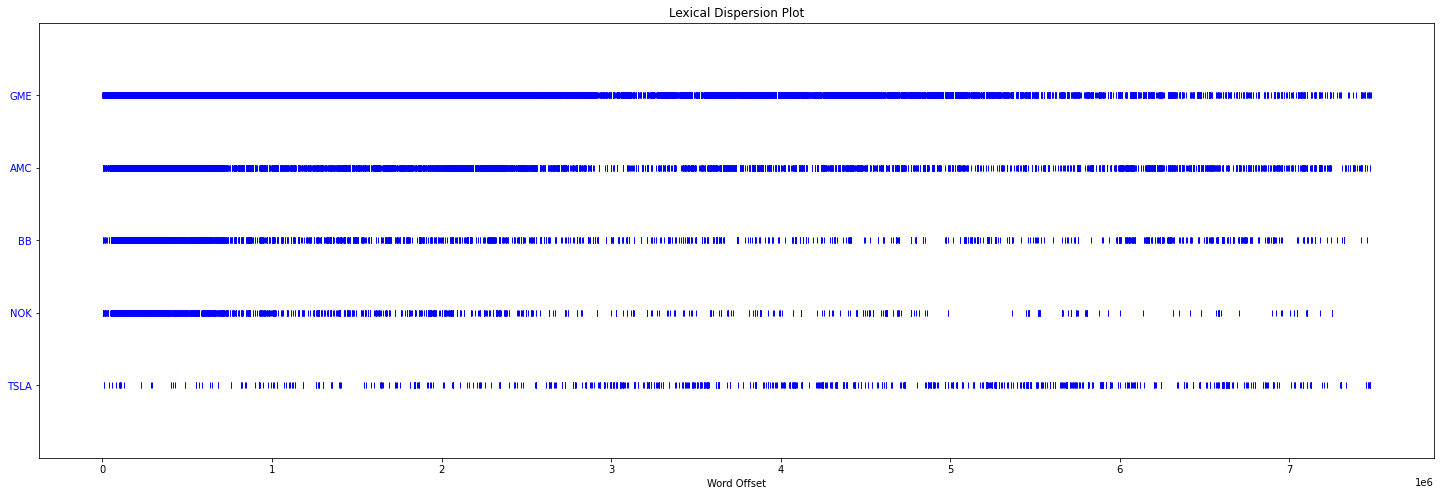

In [50]:
from nltk.draw.dispersion import dispersion_plot
colors = ["red"]
plt.figure(figsize=(25, 8))

dispersion_plot(mytext, ["GME", "AMC", "BB", "NOK", "TSLA"], title = "Lexical Dispersion Plot")

### Most Common Words on a Word Cloud

(-0.5, 399.5, 199.5, -0.5)

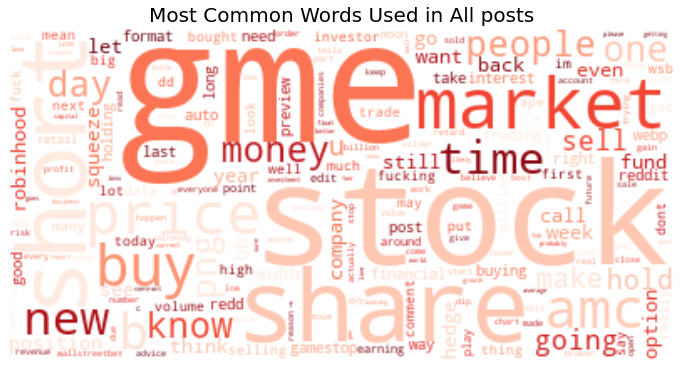

In [51]:
text = ' '.join(df["text"])
# Creating Word Cloud
title_wc = WordCloud(background_color='white', collocations = False, colormap="Reds").generate(text)
plt.figure(figsize=(12,10))
plt.imshow(title_wc, interpolation='bilinear')
plt.title('Most Common Words Used in All posts', fontsize = 20)
plt.axis('off')

## Feature Engineering

### Sentiment Analysis

In [52]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [53]:
sia.polarity_scores("GME is my favorite stock")

{'neg': 0.0, 'neu': 0.571, 'pos': 0.429, 'compound': 0.4588}

In [54]:
df["neg"] = df["text"].apply(lambda x: sia.polarity_scores(x)["neg"])
df["neu"] = df["text"].apply(lambda x: sia.polarity_scores(x)["neu"])
df["pos"] = df["text"].apply(lambda x: sia.polarity_scores(x)["pos"])
df["compound"] = df["text"].apply(lambda x: sia.polarity_scores(x)["compound"])

In [55]:
new_words = {
'citron': -4.0,  
'hidenburg': -4.0,
'green': 2.0,
'hot': 2.0,
'squeeze': 2.0,
'ape': 2.0,
'apes': 2.0,
'apes together strong': 3.0,
'roaring kitty': 2.0,
'bull': 4.0,
'bullish': 4.0,
'bear': -4.0,
'bearish': 4.0,
'bag holder': -3.0,
'bagholder': -3.0,
'bag holding': -3.0,
'bagholding': -3.0,
'hold': 2.0,
'hold the line': 3.0,
'diamond': 3.0,
'diamond hands': 3.0,
'paper hands': -3.0,
'weak hands': -3.0,
'DD': 2.0,
'double Down': 2.0,
'due diligence': 2.0,
'pump': -2.0,
'pumping': -2.0,
'dump': -2.0,
'pump and dump': -3.0,
'stonk': 2.0,
'stonks': 2.0,
'tendie' : 2.0,
'tendies': 3.0,
'YOLO': 2.0,
'moon': 3.0,
'mooning': 3.0,
'to the moon': 4.0,
'long': 2.0,
'short': -2.0,
'call': 4.0,
'calls': 4.0,
'put': -4.0,
'puts': -4.0,
'overvalued': -3.0,
'undervalued': 3.0,
'low': -2.0,
'high': 2.0,
'buy': 4.0,
'sell': -4.0,
'buy high sell low': -4.0,
'buy the dip': 3.0,
'drop': -3.0,
'rebound': 3.0,
'green': 2.0,
'rip': -3.0,
'offering': 2.0,
'rocket': 3.0,
'break': 2.0,
'we like the stock': 4.0,
'ATH': 4.0,
'IRS': -2.0,
'SEC': -3.0,
'RH': -2.0,
'robinhood': -2.0,
'IPO': 2.0,
'degenerates': -3.0,
'Stimmy': 1.5,
'checks' : 1.0,
'stimmy checks': 2.0,
'loss': -3.0,
'loss porn': -4.0,
'gain': 3.0,
'gain porn': 3.0,
'whale' : -1.0,
'HODL' : 3.0,
'autist': 2.0,
'gamestonk': 2.0,
'crayons': 2.0,
'I eat crayons': 2.0,
'boyfriend': 1.0,
'FOMO': -2.0,
'hedge': -2.0,
'hedgies': -2.0,
'hedge funds': -3.0,
'retard': 2.0,
'retards': 3.0
}

In [56]:
sia.lexicon.update(new_words)

In [57]:
df["neg_"] = df["text"].apply(lambda x: sia.polarity_scores(x)["neg"])
df["neu_"] = df["text"].apply(lambda x: sia.polarity_scores(x)["neu"])
df["pos_"] = df["text"].apply(lambda x: sia.polarity_scores(x)["pos"])
df["compound_"] = df["text"].apply(lambda x: sia.polarity_scores(x)["compound"])

In [58]:
scores = {"neg":0, "neu":0, "11-100":0, "pos":0}

for i in df["compound"]:
    if i < -0.2:
        scores["neg"] += 1
    elif i < 0.2:
        scores["neu"] += 1
    else:
        scores["pos"] += 1
        
scores_ = {"neg_":0, "neu_":0, "pos_":0}

for i in df["compound_"]:
    if i < -0.2:
        scores_["neg_"] += 1
    elif i < 0.2:
        scores_["neu_"] += 1
    else:
        scores_["pos_"] += 1

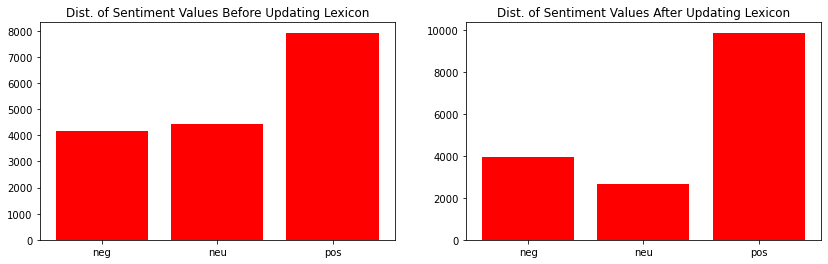

In [59]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(14,4))
axs[0].set_title("Dist. of Sentiment Values Before Updating Lexicon")
score_label = ["neg", "neu", "pos"]
value = [scores["neg"], scores["neu"], scores["pos"]]
axs[0].bar(score_label, value, color="red")

axs[1].set_title("Dist. of Sentiment Values After Updating Lexicon")
score_label = ["neg", "neu", "pos"]
value = [scores_["neg_"], scores_["neu_"], scores_["pos_"]]
axs[1].bar(score_label, value, color="red")
plt.show()

### Word Cloud for Most Common Words in Positive and Negative Posts

In [60]:
##creating dataset for positive posts
pos_cond = df["compound_"] >= 0.02
df_pos = pd.DataFrame(df[pos_cond]).reset_index()
pos_text = ' '.join(df_pos["text"])

In [61]:
##creating dataset for negative and positive posts
neg_cond = df["compound_"] < 0.2
df_neg = pd.DataFrame(df[neg_cond]).reset_index()
neg_text = ' '.join(df_neg["text"])

(-0.5, 399.5, 199.5, -0.5)

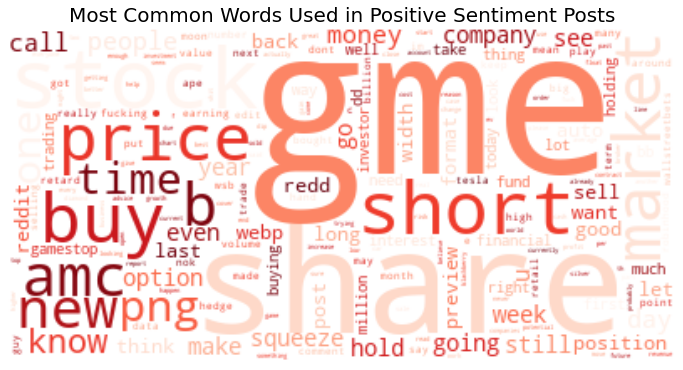

In [62]:
# Creating Word Cloud for positive words
title_wc = WordCloud(background_color='white', collocations = False, colormap="Reds").generate(pos_text)
plt.figure(figsize=(12,10))
plt.imshow(title_wc, interpolation='bilinear')
plt.title('Most Common Words Used in Positive Sentiment Posts', fontsize = 20)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

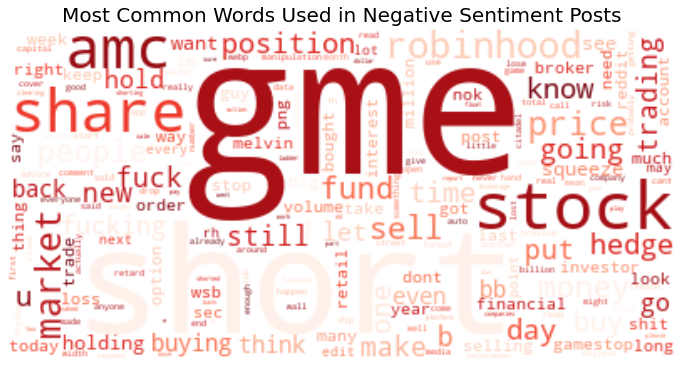

In [63]:
# Creating Word Cloud for negative words
title_wc = WordCloud(background_color='white', collocations = False, colormap="Reds").generate(neg_text)
plt.figure(figsize=(12,10))
plt.imshow(title_wc, interpolation='bilinear')
plt.title('Most Common Words Used in Negative Sentiment Posts', fontsize = 20)
plt.axis('off')

### Length of a Text

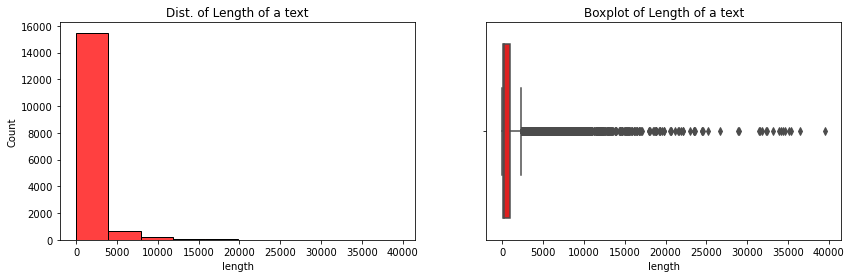

In [75]:
import seaborn as sns
from numpy import percentile

fig, axes = plt.subplots(1,2, figsize=(14,4))
sns.histplot(x=df["length"], data=df, bins=10, ax=axes[0], color="red")
axes[0].set_title("Dist. of Length of a text")

sns.boxplot(x=df["length"], data=df, ax=axes[1], color="red")
axes[1].set_title("Boxplot of Length of a text")
plt.show()

### Lexical Diversity

In [64]:
##create diversity score
def lexical_diversity(my_text_data):
    words = [nltk.word_tokenize(text) for text in my_text_data]
    word_count = len(my_text_data)
    vocab_size = len(set(my_text_data))
    diversity_score = vocab_size / word_count
    return diversity_score

In [65]:
df["lexical_diversity"] = df["text"].apply(lambda x: lexical_diversity(x))

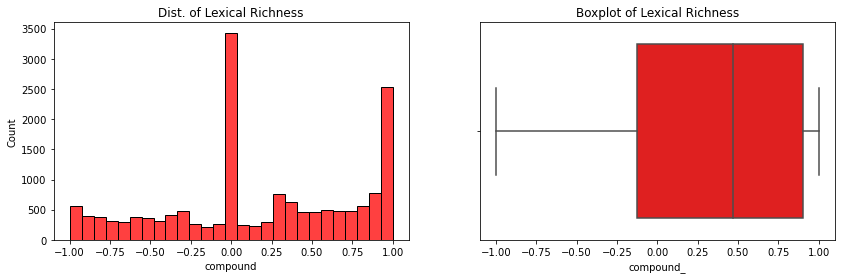

In [67]:
import seaborn as sns
from numpy import percentile

fig, axes = plt.subplots(1,2, figsize=(14,4))

sns.histplot(x=df["compound"], data=df, ax=axes[0], color="red")
axes[0].set_title("Dist. of Lexical Richness")


sns.boxplot(x=df["compound_"], data=df, ax=axes[1], color="red")
axes[1].set_title("Boxplot of Lexical Richness")
plt.show()

### Most Frequent Unigrams and Bigrams

In [68]:
##creating a list of most common Unigrams 
text=list(df['text'])
words = [nltk.word_tokenize(t) for t in text]

In [ ]:
word=[w for word in words for w in word]
fdist=nltk.FreqDist(w for w in word)

In [69]:
unigrams = [item[0] for item in fdist.most_common(20)]
frquni = [item[1] for item in fdist.most_common(20)]

In [72]:
##creating a list of most common bigrams
fdist=nltk.FreqDist((x,y) for (x,y) in nltk.bigrams(word))
most_common=fdist.most_common(20)

In [73]:
top_words=[word for (word, freq) in most_common]
frqbi = [freq for (word, freq) in most_common]
bigrams = [' '.join(i) for i in top_words]

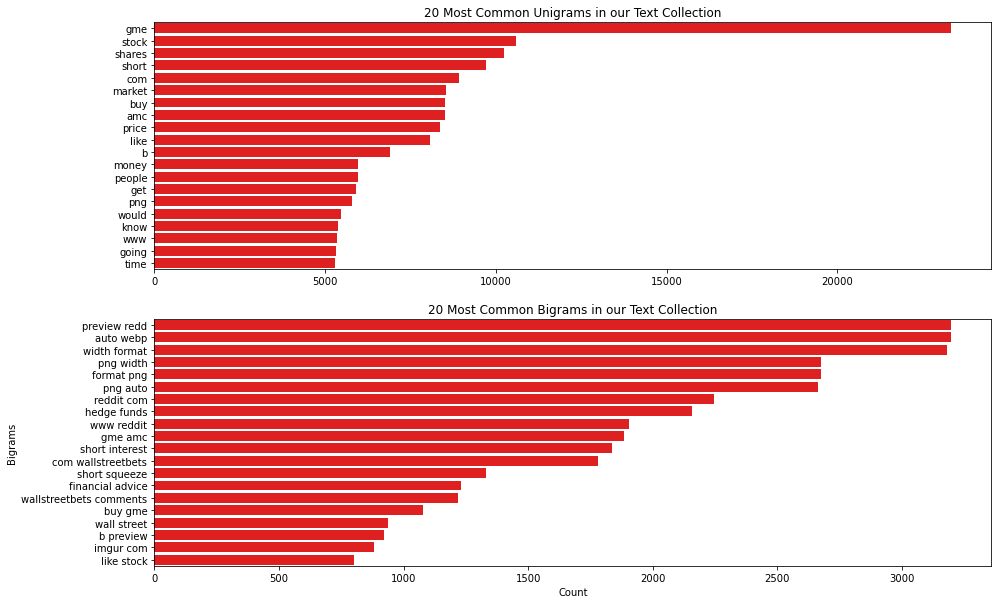

In [74]:
fig, axes = plt.subplots(2,1, figsize=(15,10))

sns.barplot(y=unigrams, x=frquni, color="red", ax=axes[0]).set(title='20 Most Common Unigrams in our Text Collection')
plt.xlabel("Count")
plt.ylabel("Unigrams")

sns.barplot(y=bigrams, x=frqbi, color="red", ax=axes[1]).set(title='20 Most Common Bigrams in our Text Collection')
plt.xlabel("Count")
plt.ylabel("Bigrams")

plt.show()